# Estimating object location from noisy radar echos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
mkl.set_num_threads(4)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Usefull imports

In [2]:
from scipy.stats import multivariate_normal as mvn
from numpy.linalg import inv

## Useful utility functions

In [3]:
# Plot 'iso-densities' for MVN
#   ax - axis for plotting,
#   mu, Sigma - MVN parameters,
#   observations - observations (data points) to mark on the plot,
#   title - plot title.
def plot_mvn(ax, mu, Sigma, observations = None, title = None,
             xmin=-10, xmax=10, ymin=-10, ymax=10, grid_size = 100):
    X = np.linspace(xmin, xmax, grid_size)
    Y = np.linspace(ymin, ymax, grid_size)
    X, Y = np.meshgrid(X, Y)
    grid = np.vstack([X.flatten(), Y.flatten()]).T
    
    p = mvn(mu, Sigma)
    density = p.pdf(grid).reshape((grid_size, grid_size))
    
    c = ax.contour(X, Y, density, zorder=1)
#     print("Contour levels:", c.levels)
    
    if observations is not None:
        if len(observations.shape) == 1:
            ox, oy = observations[0], observations[1]
        else:
            ox, oy = observations[:, 0], observations[:, 1]
            
        ax.scatter(ox, oy, s=100, c='r', marker='x', zorder=2)
    
    if title is not None:
        ax.set_title(title)
    
    ax.axis('equal')
    plt.show

## Estimating object location from (one) noisy radar echo

Our task is to estimate location of a stationary object from its radar echo.

Assumptions:
- radar plane is a $[-10, 10] \times [-10, 10]$ rectangle,
- radar echo gives us a noisy measurement of the true location,
- the measurement noise is well modeled by a multivariate Gaussian with precision: `radar_echo_Prec`.

In [4]:
radar_echo_Sigma = np.array([[2, -1.5],
                             [-1.5, 2]])

radar_echo_Prec = inv(radar_echo_Sigma)

For now, we have only one radar echo to work with. It is stored in: `radar_echo`.

In the code below, `true_x` is the true location of the object on the radar plane. We imagine that we do not know this location (our task is to estimate it).

In [5]:
true_x = np.array([5.0, 5.0])

radar_echo = mvn.rvs(true_x, radar_echo_Sigma, size=1, random_state=1234)

---

Propose (and be ready do justify) a probabilistic model for estimating object location from the radar echo. This model must:
1. estimate a likely location of the object,
1. estimate uncertainty in the (estimated) object location.

From working experience with our radar we know that objects are most often located in a sphere with radius $r=3$ centered in the radar plane.

---

Implement the proposed model in `estimate_location_from_echo` function. The arguments to this function should be:
- radar echo,
- parameters of the probability distribution that expresses our prior assumptions about object location.

`estimate_location_from_echo` should return parameters of the probability distribution that expresses our beliefs about object location after observing one radar echo.

In [6]:
def estimate_location_from_echo(radar_echo, x_mu, x_sigma):
    x_prec = inv(x_sigma)
    
    y = radar_echo
    y_sigma = radar_echo_Sigma
    y_prec = radar_echo_Prec
    
    x_y_sigma = inv(x_prec + y_prec)
    x_y_mu = x_y_sigma @ (y_prec @ y + x_prec @ x_mu)
    
    return x_y_mu, x_y_sigma

Now, use `estimate_location_from_echo` to estimate object location (and uncertainty). Then use `plot_mvn` function to plot two 'iso-density' plots:
- one for our prior assumptions about object location - this should be plotted in `ax[0]` axes,
- one for estimated object location and its uncertainty - this should be plotted in `ax[1]` axes and include location of the radar echo.

In [7]:
from scipy import integrate

prior_mu = np.array([0, 0])
prior_sigma = np.array([[4, 0],
                        [0, 4]])

p = mvn(prior_mu, prior_sigma)
f = lambda y, x: p.pdf([x, y]) if x ** 2 + y ** 2 < 9 else 0

probability_in_rad_3 = integrate.dblquad(f, -3, 3, lambda x: -3, lambda x: 3, epsabs=1e-02, epsrel=1e-02)
print(f"Prior probability in a sphere with radius r=3 centered in the radar plane: \n{ probability_in_rad_3 }")

Prior probability in a sphere with radius r=3 centered in the radar plane: 
(0.6751173738592912, 0.009560189910261325)


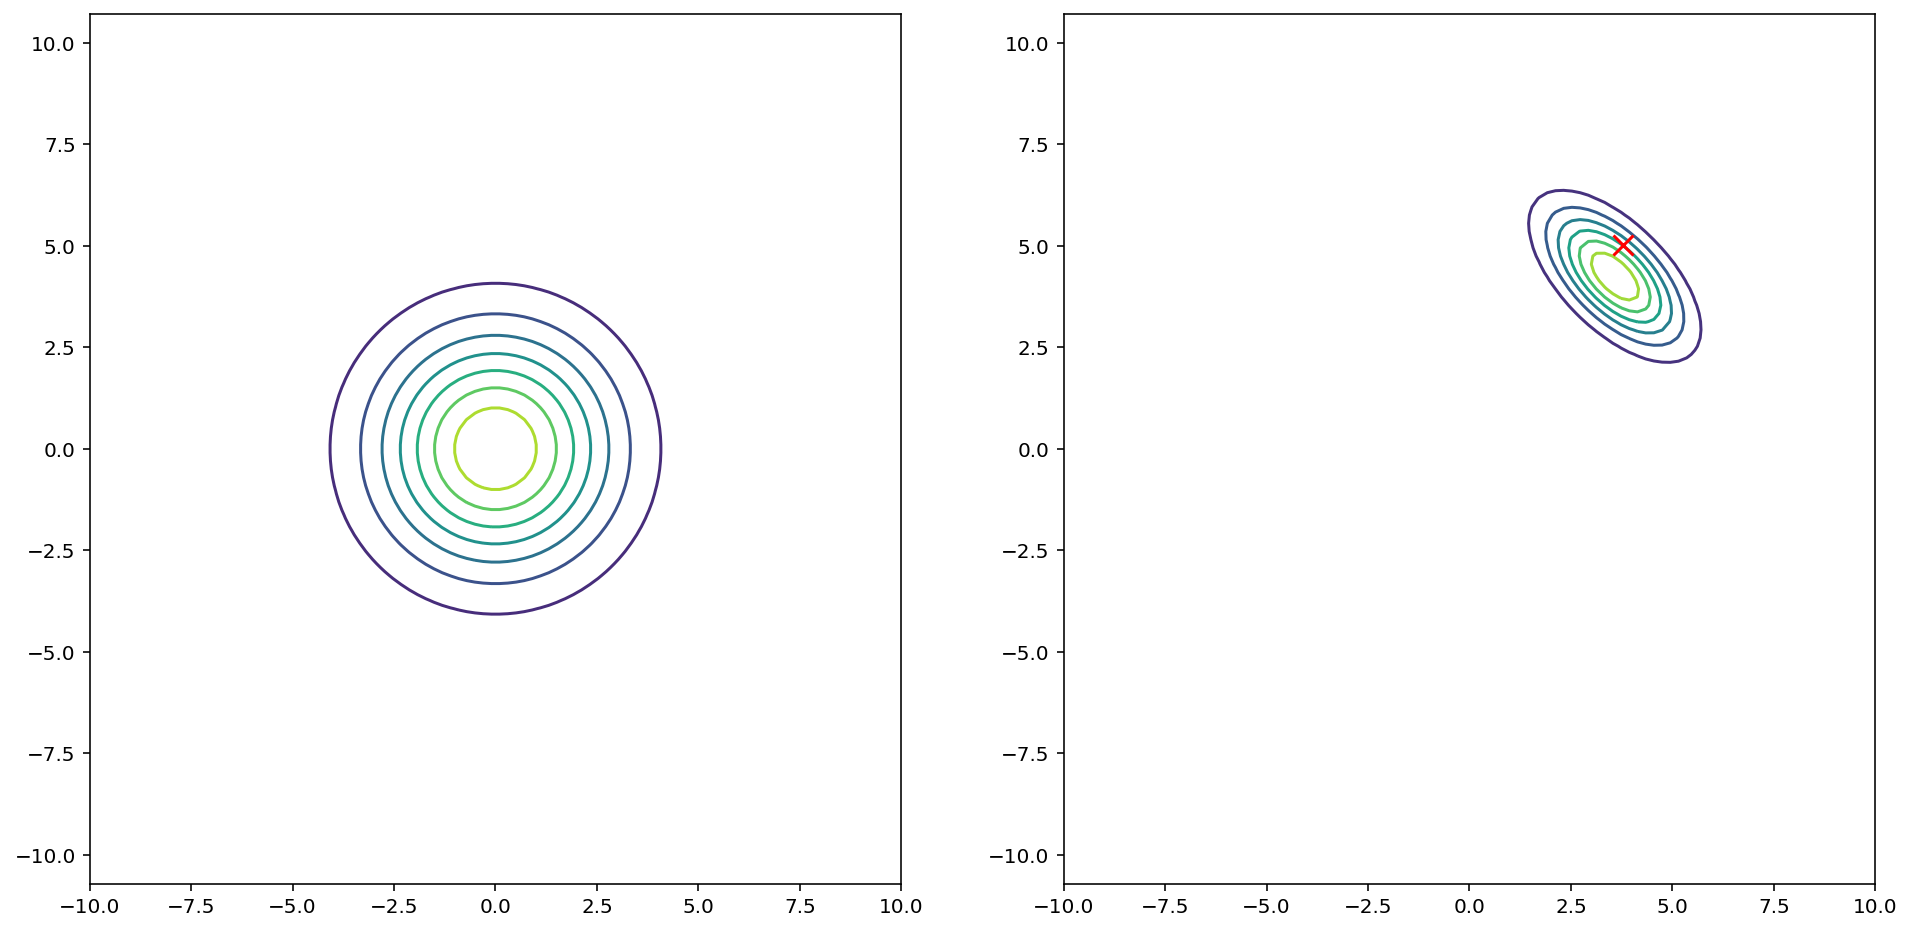

In [8]:
_, ax = plt.subplots(1, 2, figsize=(16,8))

posterior_mu, posterior_sigma = estimate_location_from_echo(radar_echo, prior_mu, prior_sigma)

plot_mvn(ax[0], prior_mu, prior_sigma)
plot_mvn(ax[1], posterior_mu, posterior_sigma, radar_echo)

## Estimating object location from multiple noisy radar echos

Now imagine that we have $N$ radar echos for a single object (we made $N$ independent radar scans). These echos are stored in `radar_echo_n`.

In [9]:
N=5

radar_echo_n = mvn.rvs(true_x, radar_echo_Sigma, size=N, random_state=1234)

Our goal is to estimate object location (and uncertainty) from all these radar scans. One simple option is to iteratively update our beliefs about object location as new echos arrive.

That is:
- we start with prior assumptions about object location,
- we update our beliefs about object location when we observe a radar echo,
- once we observe another radar echo, we can treat our current beliefs about object location (estimated above) as prior assumptions,
- we can continue in this iterative manner until we accounted for evidence from all observed echos.

---

Implement the iterative procedure described above to estimate object location (and uncertainty) from all radar echos stored in `radar_echo_n`. Use `estimate_location_from_echo` function for updating beliefs about object location.

In [10]:
def estimate_location_from_echos(radar_echo_n, x_mu, x_sigma):
    x_y_mu, x_y_sigma = x_mu, x_sigma
    
    for radar_echo in radar_echo_n:
        x_y_mu, x_y_sigma = estimate_location_from_echo(radar_echo, x_y_mu, x_y_sigma)
    
    return x_y_mu, x_y_sigma

Use `plot_mvn` function to plot two 'iso-density' plots:
- one for prior assumptions about object location - this should be plotted in `ax[0]` axes,
- one for estimated object location and its uncertainty - this should be plotted in `ax[1]` axes and include locations of all radar echos stored in `radar_echo_n`.

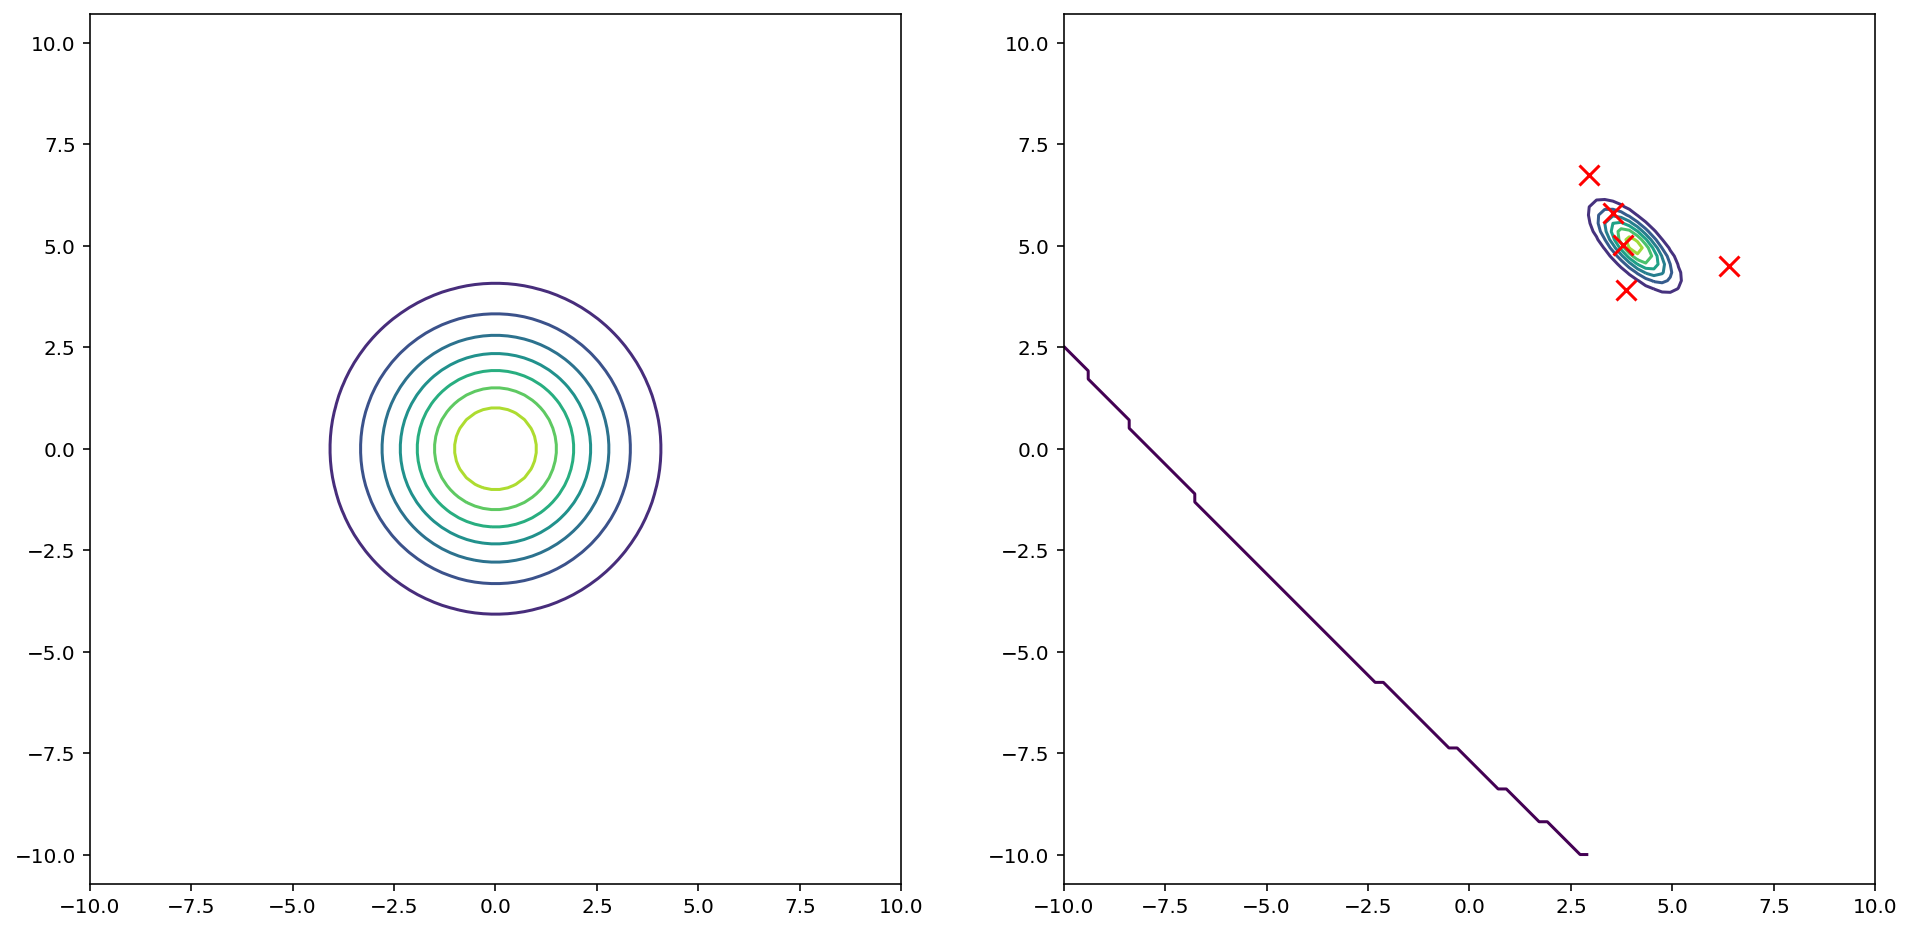

In [11]:
_, ax = plt.subplots(1, 2, figsize=(16,8))

posterior_mu, posterior_sigma = estimate_location_from_echos(radar_echo_n, prior_mu, prior_sigma)

plot_mvn(ax[0], prior_mu, prior_sigma)
plot_mvn(ax[1], posterior_mu, posterior_sigma, radar_echo_n)

The iterative update procedure implemented above has one drawback - it's not efficient (computationally).

If you came up with a sensible probabilistic model it should be possible to derive equations for estimating object location (and uncertainty) from all radar echos (in a single pass). Try to write down these equations and implement them in `estimate_location_from_echo_batch` function. The arguments to this function should be:
- radar echos (in a NumPy array),
- parameters of the probability distribution that expresses our prior assumptions about object location.

`estimate_location_from_echo_batch` should return parameters of the probability distribution that expresses our beliefs about object location after observing all radar echos.

---

Hint: try to write down parameters of the probability distribution over object location after:
- observing one echo, e.g. $e_1$,
- then observing another echo, e.g. $e_2$.

Guess a form of the batch-update equations from these examples. Then prove by induction that it is correct.

Korzystając z wzorów z wykładu wiemy, że:

dla priora $x$ ~ $N(\mu_x, \Sigma_x)$ oraz $y$ | $x$ ~ $N(Ax + b, \Sigma_y)$

otrzymujemy rozkład a posteriori postaci $x$ | $y$ ~ $N(\mu_{x|y}, \Sigma_{x|y})$, gdzie:

$\Sigma_{x|y} = [\Sigma_x^{-1} + A^T \Sigma_y^{-1} A]^{-1}$  
$\mu_{x|y} = \Sigma_{x|y} [\left( A^T \Sigma_y^{-1} (y-b) \right) + \Sigma_x^{-1} \mu_x]$

Dla naszego problemu przyjmujemy $A=I$ oraz $b=\vec{0}$, więc wzory uproszczą się do:

$\Sigma_{x|y} = [\Sigma_x^{-1} + \Sigma_y^{-1}]^{-1}$  
$\mu_{x|y} = \Sigma_{x|y} [\Sigma_y^{-1} y + \Sigma_x^{-1} \mu_x]$

Rozpiszmy dla 2 pierwszych pomiarów:

Po 1 obserwacji dostajemy posterior:
$$(\Sigma_{x|y})_1 = [(\Sigma_x^{-1})_1 + \Sigma_y^{-1}]^{-1}$$ 
$$(\mu_{x|y})_1 = (\Sigma_{x|y})_1 [\Sigma_y^{-1} y_1 + (\Sigma_x^{-1})_1 (\mu_x)_1]$$

Jako prior do obliczeń dla 2 obserwacji przyjmujemy posterior z pierwszej:
$$(\Sigma_x^{-1})_2 = (\Sigma_{x|y})_1$$
$$(\mu_x)_2 = (\mu_{x|y})_1$$

Po 2 obserwacji dostajemy posterior:
$$(\Sigma_{x|y})_2 = [(\Sigma_{x|y}^{-1})_1 + \Sigma_y^{-1}]^{-1} = [(\Sigma_x^{-1})_1 + \Sigma_y^{-1} + \Sigma_y^{-1}]^{-1} = [(\Sigma_x^{-1})_1 + 2 \cdot \Sigma_y^{-1}]^{-1} $$  
$$(\mu_{x|y})_2 = (\Sigma_{x|y})_2 [\Sigma_y^{-1} y_2 + (\Sigma_{x|y}^{-1})_1 (\Sigma_{x|y})_1 [\Sigma_y^{-1} y_1 + (\Sigma_x^{-1})_1 (\mu_x)_1]] = (\Sigma_{x|y})_2 [\Sigma_y^{-1} y_2 + \Sigma_y^{-1} y_1 + (\Sigma_x^{-1})_1 (\mu_x)_1]$$

Na podstawie tego możemy zaproponować, że dla priora $x$ ~ $N(\mu_x, \Sigma_x)$ oraz $y$ | $x$ ~ $N(x, \Sigma_y)$
Po obserwacji $n$ danych otrzymamy posterior:
$$ \Sigma_{x|y} = \left[\Sigma_x^{-1} + n \cdot \Sigma_y^{-1}\right]^{-1} $$
$$ \mu_{x|y} = \Sigma_{x|y} \left[\left(\sum_{i=1}^{n} \Sigma_y^{-1} y_i\right) + \Sigma_x^{-1} \mu_x\right] $$

Dowód przez indukcję:
- dla n = 1 dostajemy zwykły liniowy model Gaussowski zatem warunek początkowy jest spełniony
- tworzymy hipotezę indukcyjną, że wzór jest poprawny dla n, czyli:
$$ (\Sigma_{x|y})_n = \left[\Sigma_x^{-1} + n \cdot \Sigma_y^{-1}\right]^{-1} $$
$$ (\mu_{x|y})_n = (\Sigma_{x|y})_n \left[\left(\sum_{i=1}^{n} \Sigma_y^{-1} y_i\right) + \Sigma_x^{-1} \mu_x\right] $$
- należy teraz wykazać, że wzór zachodzi dla n + 1, zatem:
$$ (\Sigma_{x|y})_{n+1} = \left[(\Sigma_{x|y}^{-1})_n + \Sigma_y^{-1}\right]^{-1} = \left[\Sigma_x^{-1} + n \cdot \Sigma_y^{-1} + \Sigma_y^{-1}\right]^{-1} = \left[\Sigma_x^{-1} + (n + 1) \cdot \Sigma_y^{-1}\right]^{-1} $$

$$ (\mu_{x|y})_{n+1} = (\Sigma_{x|y})_{n+1} \left[\Sigma_y^{-1} y_{n+1} + (\Sigma_{x|y}^{-1})_n (\mu_{x|y})_n \right]
= (\Sigma_{x|y})_{n+1} \left[\Sigma_y^{-1} y_{n+1} + (\Sigma_{x|y}^{-1})_n (\Sigma_{x|y})_n \left[\left(\sum_{i=1}^{n} \Sigma_y^{-1} y_i\right) + \Sigma_x^{-1} \mu_x\right] \right]
= (\Sigma_{x|y})_{n+1} \left[\left(\sum_{i=1}^{n+1} \Sigma_y^{-1} y_i\right) + \Sigma_x^{-1} \mu_x \right]$$
- zatem wzór jest poprawny dla każdego $n \geq 1$

Dodatkowo korzystając z własności działań na macierzach możemy uprościć sumę:
$$\sum_{i=1}^{n} \Sigma_y^{-1} y_i = \Sigma_y^{-1} \sum_{i=1}^{n} y_i $$

In [12]:
def estimate_location_from_echo_batch(radar_echo_n, x_mu, x_sigma):
    n = radar_echo_n.shape[0]
    
    x_prec = inv(x_sigma)
    
    y = radar_echo_n
    y_sigma = radar_echo_Sigma
    y_prec = radar_echo_Prec
    
    x_y_sigma = inv(x_prec + n * y_prec)
    x_y_mu = x_y_sigma @ (y_prec @ np.sum(y, axis=0) + x_prec @ x_mu)
    
    return x_y_mu, x_y_sigma

Use `estimate_location_from_echo_batch` to estimate object location (and uncertainty) from all radar echos.

Next, use `plot_mvn` function to make 'iso-density' plots identical to the ones above, but using location and uncertainty estimates from `estimate_location_from_echo_batch`.

Verify that estimates from `estimate_location_from_echo_batch` agree with the ones from the iterative update procedure.

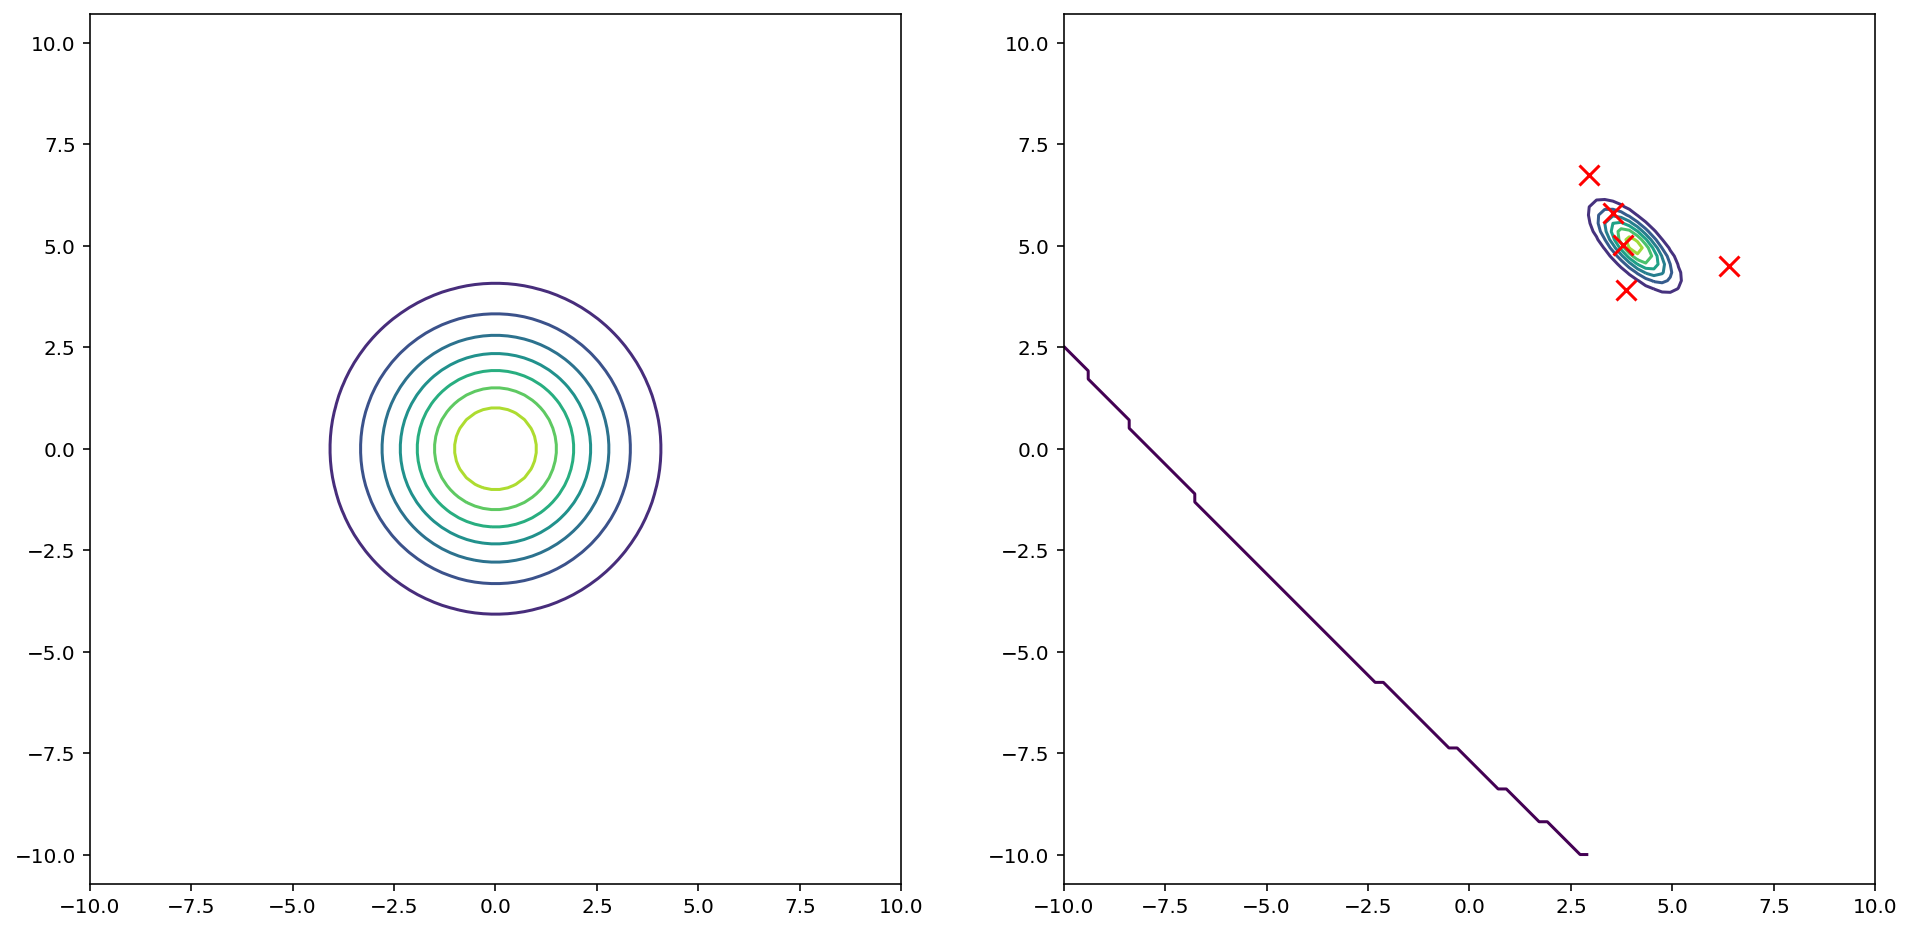

In [14]:
_, ax = plt.subplots(1, 2, figsize=(16,8))

posterior_mu, posterior_sigma = estimate_location_from_echo_batch(radar_echo_n, prior_mu, prior_sigma)

plot_mvn(ax[0], prior_mu, prior_sigma)
plot_mvn(ax[1], posterior_mu, posterior_sigma, radar_echo_n)

Weryfikacja poprwaności przez porównanie wyniku z metodą iteracyjną:

In [20]:
posterior_mu1, posterior_sigma1 = estimate_location_from_echo_batch(radar_echo_n, prior_mu, prior_sigma) 
posterior_mu2, posterior_sigma2 = estimate_location_from_echos(radar_echo_n, prior_mu, prior_sigma)

print(np.allclose(posterior_mu1, posterior_mu2))
print(np.allclose(posterior_sigma1, posterior_sigma2))

True
True
